In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity



df = pd.read_csv("user_ratings.csv")
df

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP
...,...,...,...
18942210,165521,3.0,rseater
18942211,165521,3.0,Bluefox86
18942212,165521,3.0,serginator
18942213,193488,1.0,CaptainCattan


In [2]:
le = LabelEncoder()
le.fit_transform(df['Username'])

array([195785, 385050, 200126, ..., 371648,  30181, 394601],
      shape=(18942215,))

In [3]:
df['Username_Encoded'] = le.transform(df['Username'])

In [4]:
# Depcting that 'Tonydorrf' has a specific encoded value with multiple Board Game Reviews
df.where(df['Username'] == 'Tonydorrf').dropna()

,BGGId,Rating,Username,Username_Encoded
0,213788.0,8.0,Tonydorrf,195785.0
103768,206593.0,8.0,Tonydorrf,195785.0
147923,267333.0,7.0,Tonydorrf,195785.0
171368,249824.0,6.0,Tonydorrf,195785.0
184232,301085.0,6.0,Tonydorrf,195785.0
...,...,...,...,...
18801954,252314.0,7.0,Tonydorrf,195785.0
18826671,176247.0,8.0,Tonydorrf,195785.0
18901732,259857.0,7.0,Tonydorrf,195785.0
18905081,246530.0,7.0,Tonydorrf,195785.0


In [5]:
df['Username_Encoded'] = df['Username_Encoded'].astype(np.int32)
df['Rating'] = df['Rating'].astype(np.int16)
df['BGGId'] = df['BGGId'].astype(np.int32)
df.dtypes

BGGId                int32
Rating               int16
Username            object
Username_Encoded     int32
dtype: object

In [6]:
df

,BGGId,Rating,Username,Username_Encoded
0,213788,8,Tonydorrf,195785
1,213788,8,tachyon14k,385050
2,213788,8,Ungotter,200126
3,213788,8,brainlocki3,236689
4,213788,8,PPMP,144112
...,...,...,...,...
18942210,165521,3,rseater,365759
18942211,165521,3,Bluefox86,22977
18942212,165521,3,serginator,371648
18942213,193488,1,CaptainCattan,30181


In [7]:
# Randomly select .1% of the data, in stretches of consecutive BGGId values
df_sampled = (
    df.groupby('BGGId', group_keys=False)[['BGGId', 'Rating', 'Username', 'Username_Encoded']]
      .apply(lambda x: x.sample(frac=0.001, random_state=42))
      .reset_index(drop=True)
)

#df_sampled = df.sample(frac=0.01, random_state=42)
df_sampled

,BGGId,Rating,Username,Username_Encoded
0,1,9,thedirtyhamm,388576
1,1,7,RocketSkunk,161894
2,1,6,Craigthulu,38438
3,1,9,Lassonius,108428
4,1,7,rainian44,358660
...,...,...,...,...
17115,338628,7,magnitt,323191
17116,340466,7,Bayushi Sezaru,18065
17117,342942,9,DoctorPhil,50091
17118,343905,8,LanceCorporal,107914


In [8]:
# Save the sampled data to a new CSV file
df_sampled.to_csv("user_ratings_sampled.csv", index=False)

# Create a recommendation System that:
- Recommend *New* BoardGameIDs to a User
    - Inputs a user
    - Outpus BoardGame Recommendations
- Allows a user to see which BoardGames are similar to another BoardGame
    - Inputs a BoardGame
    - Ouputs a Recommended BoardGame

In [9]:
sampled_df = pd.read_csv("user_ratings_sampled.csv")

## Quickly inspect the data (EDA)

In [10]:
sampled_df.sample(20)

,BGGId,Rating,Username,Username_Encoded
8283,101785,8,Slymous,176455
11041,156091,8,FelixInc,62621
13562,193668,7,AmazonQueen84,7772
232,18,8,Doerk,50192
13796,198138,8,quendae,357525
1574,822,9,CaptainKarma,30245
12959,180974,6,Luisjoey,114881
4141,15512,7,jerryyeti,297992
15063,229853,7,FraPas13,65796
465,88,8,Dragonshadow,52402


## Using the BGGId and Username_Encoded Features; Create the Sparse (Mostly NaN) User-Item Matrix via pivot table

In [11]:
User_Item_df = sampled_df.pivot_table(
    index='Username_Encoded',
    columns='BGGId',
    values='Rating',
    aggfunc='mean'  # or 'sum', 'max', etc. 
)
User_Item_df

BGGId,1,2,3,5,7,9,10,11,12,13,...,330608,331050,332290,332386,332800,338628,340466,342942,343905,346703
Username_Encoded,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


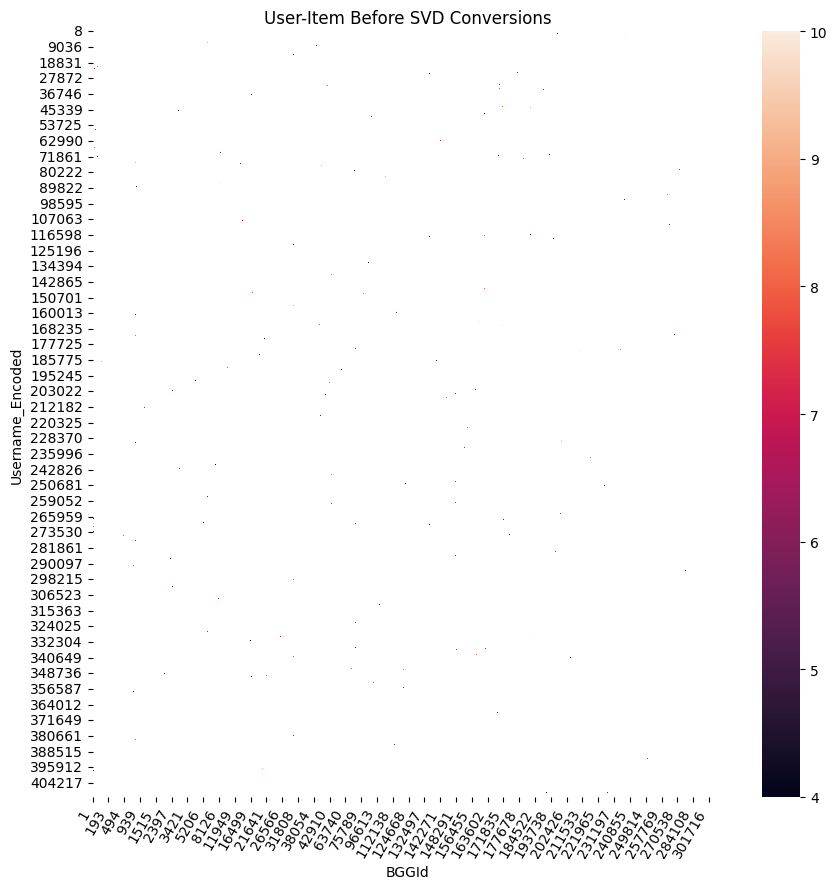

In [12]:
makeNewHeatmaps = True

if makeNewHeatmaps:   
    plt.figure(figsize=(9,9))
    sns.heatmap(data=User_Item_df, annot=False, robust=True)
    plt.xticks(rotation=60, ha='right')  # Rotates x-axis labels for better readability
    plt.title("User-Item Before SVD Conversions")
    plt.tight_layout()

## Perform SVD, then recostruct the User-Item Matrix

In [13]:
'''
SVD has a time complexity of 𝑂(𝑛𝑚𝑘), 
where n is the number of users, 
m is the number of items, 
and 𝑘 is the number of latent factors. 
For reasonable values of 𝑘
k (e.g., 20 to 100), matrix factorization can be significantly faster, especially when the number of users and items is large.
'''

# Step 1: Fill NaN with 0 or some other placeholder
User_Item_filled = User_Item_df.fillna(0)

# Step 2: Apply Truncated SVD to reduce dimensionality
n_components = 20  # Number of latent features 
svd = TruncatedSVD(n_components=n_components)
user_latent = svd.fit_transform(User_Item_filled)

# Step 3: Reconstruct the original matrix using the latent features
User_Item_reconstructed = np.dot(user_latent, svd.components_)

# Convert the reconstructed matrix back to a DataFrame
User_Item__reconstructed_df = pd.DataFrame(User_Item_reconstructed, index=User_Item_df.index, columns=User_Item_df.columns)

# Step 4: Replace original NaN values with the reconstructed values
UBCF_User_Item_df = User_Item_df.copy()

# Only fill NaN values with reconstructed values
UBCF_User_Item_df = UBCF_User_Item_df.where(~UBCF_User_Item_df.isna(), User_Item_reconstructed)


In [14]:
UBCF_User_Item_df

BGGId,1,2,3,5,7,9,10,11,12,13,...,330608,331050,332290,332386,332800,338628,340466,342942,343905,346703
Username_Encoded,,,,,,,,,,,,,,,,,,,,,
8,-9.721040e-13,-2.364692e-18,-2.989950e-13,3.816381e-13,5.098711e-19,-4.025590e-22,3.679522e-15,-3.740188e-11,-1.034787e-13,-1.006068e-11,...,-5.081964e-22,-2.167663e-22,4.104316e-20,1.597455e-22,-5.248087e-20,-4.211562e-15,-4.087891e-15,-7.217806e-21,-3.200468e-20,-3.724173e-20
42,-1.560358e-11,-1.799885e-17,-6.313145e-12,3.527849e-12,4.717840e-18,-1.189546e-20,-3.668643e-14,3.492191e-11,5.711706e-12,-5.480648e-10,...,1.375377e-20,8.763700e-21,-6.944278e-19,-1.621665e-20,-2.436430e-19,-3.443131e-14,-4.620891e-14,-3.649681e-18,-9.241511e-19,-6.527244e-19
75,-3.276991e-04,-5.019629e-10,-9.339202e-05,5.282410e-05,3.096072e-11,-7.222038e-14,7.082976e-08,-8.542924e-04,9.104794e-05,2.511232e-05,...,-2.144926e-13,-6.666135e-14,1.169432e-11,-1.267575e-13,-7.524229e-12,-2.993502e-07,-3.747449e-08,1.975832e-11,2.079337e-12,-3.290239e-12
141,3.451420e-10,7.681845e-16,7.037088e-11,-1.951149e-11,4.879671e-17,-9.689003e-20,2.628240e-13,4.160580e-09,-1.962409e-10,-9.865922e-09,...,3.254341e-19,1.245302e-19,-9.946860e-18,-7.838978e-20,3.216773e-18,1.615206e-13,1.033831e-14,-7.983483e-18,-4.724213e-18,-4.097811e-18
144,-1.253872e-13,-1.541714e-18,-1.752369e-13,-2.181765e-14,-8.105740e-19,1.900128e-21,-1.083668e-14,1.008812e-10,1.091186e-12,-2.547529e-11,...,-1.166775e-21,-6.206498e-22,8.910226e-20,-1.248270e-21,7.062894e-20,7.116592e-15,5.837744e-15,-2.305859e-19,4.754901e-20,6.816804e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411262,3.215096e-09,7.271992e-15,2.323525e-09,-9.388208e-10,-5.759189e-16,1.355472e-18,2.110054e-11,-1.909195e-07,-6.698037e-10,3.522148e-07,...,2.870936e-18,-3.890397e-19,-5.120813e-17,7.938043e-18,4.498525e-18,-5.390524e-12,-3.858735e-12,5.108316e-16,-7.251085e-17,6.321133e-17
411265,-3.498337e-12,-6.454326e-18,-1.218608e-14,8.934179e-13,1.700901e-18,-3.835175e-22,1.603775e-14,-2.006853e-10,-1.044121e-12,8.227244e-11,...,-1.898327e-22,-1.624079e-22,-1.390949e-20,4.326101e-21,-1.656694e-19,-1.679059e-14,-1.456714e-14,-5.632635e-20,-1.601162e-19,-1.302078e-19
411297,-2.411090e-09,-5.678131e-15,-9.861135e-10,5.301834e-10,1.108528e-15,-2.703890e-18,1.411697e-12,-1.800834e-08,2.206473e-09,-8.504880e-08,...,-3.157153e-19,6.162147e-19,-1.224545e-16,-2.196333e-18,-1.021321e-16,-1.004718e-12,4.517329e-13,5.665554e-17,-4.895716e-17,-1.286230e-16


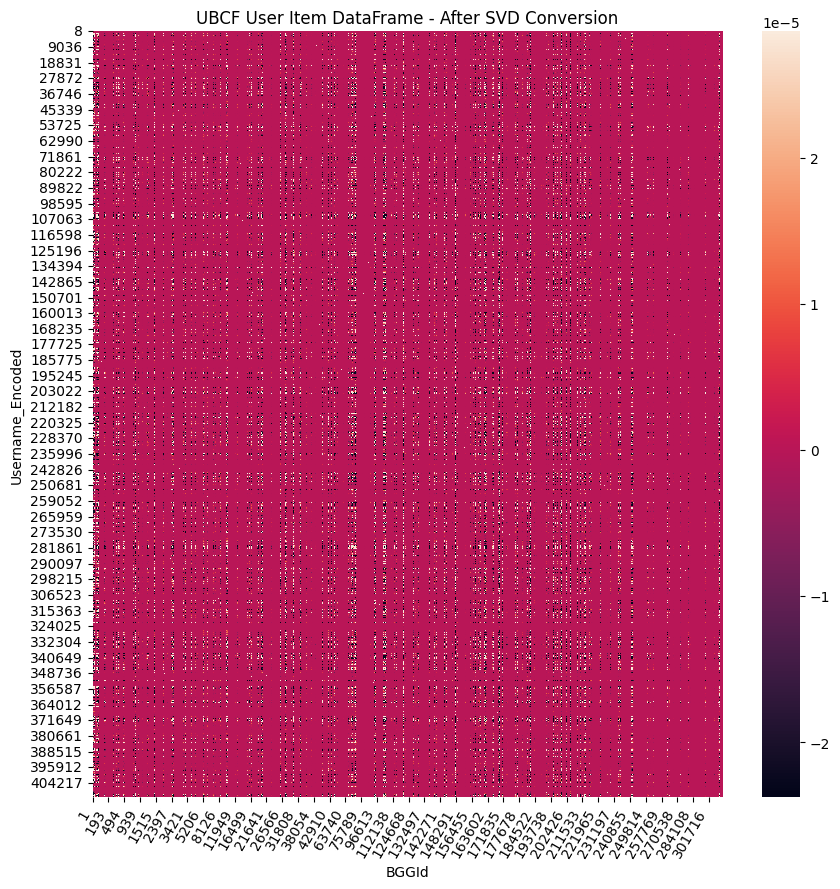

In [15]:
if makeNewHeatmaps:   
    plt.figure(figsize=(9,9))
    sns.heatmap(data=UBCF_User_Item_df, annot=False, robust=True)
    plt.xticks(rotation=60, ha='right')  # Rotates x-axis labels for better readability
    plt.title('UBCF User Item DataFrame - After SVD Conversion')
    plt.tight_layout()

In [16]:
# Check for constant columns and remove them
constant_columns = [col for col in UBCF_User_Item_df.columns if UBCF_User_Item_df[col].nunique() <= 1]
UBCF_User_Item_df_clean_SVD = UBCF_User_Item_df.drop(columns=constant_columns)
UBCF_User_Item_df_clean_SVD
UBCF_User_Item_df_clean_SVD

BGGId,1,2,3,5,7,9,10,11,12,13,...,330608,331050,332290,332386,332800,338628,340466,342942,343905,346703
Username_Encoded,,,,,,,,,,,,,,,,,,,,,
8,-9.721040e-13,-2.364692e-18,-2.989950e-13,3.816381e-13,5.098711e-19,-4.025590e-22,3.679522e-15,-3.740188e-11,-1.034787e-13,-1.006068e-11,...,-5.081964e-22,-2.167663e-22,4.104316e-20,1.597455e-22,-5.248087e-20,-4.211562e-15,-4.087891e-15,-7.217806e-21,-3.200468e-20,-3.724173e-20
42,-1.560358e-11,-1.799885e-17,-6.313145e-12,3.527849e-12,4.717840e-18,-1.189546e-20,-3.668643e-14,3.492191e-11,5.711706e-12,-5.480648e-10,...,1.375377e-20,8.763700e-21,-6.944278e-19,-1.621665e-20,-2.436430e-19,-3.443131e-14,-4.620891e-14,-3.649681e-18,-9.241511e-19,-6.527244e-19
75,-3.276991e-04,-5.019629e-10,-9.339202e-05,5.282410e-05,3.096072e-11,-7.222038e-14,7.082976e-08,-8.542924e-04,9.104794e-05,2.511232e-05,...,-2.144926e-13,-6.666135e-14,1.169432e-11,-1.267575e-13,-7.524229e-12,-2.993502e-07,-3.747449e-08,1.975832e-11,2.079337e-12,-3.290239e-12
141,3.451420e-10,7.681845e-16,7.037088e-11,-1.951149e-11,4.879671e-17,-9.689003e-20,2.628240e-13,4.160580e-09,-1.962409e-10,-9.865922e-09,...,3.254341e-19,1.245302e-19,-9.946860e-18,-7.838978e-20,3.216773e-18,1.615206e-13,1.033831e-14,-7.983483e-18,-4.724213e-18,-4.097811e-18
144,-1.253872e-13,-1.541714e-18,-1.752369e-13,-2.181765e-14,-8.105740e-19,1.900128e-21,-1.083668e-14,1.008812e-10,1.091186e-12,-2.547529e-11,...,-1.166775e-21,-6.206498e-22,8.910226e-20,-1.248270e-21,7.062894e-20,7.116592e-15,5.837744e-15,-2.305859e-19,4.754901e-20,6.816804e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411262,3.215096e-09,7.271992e-15,2.323525e-09,-9.388208e-10,-5.759189e-16,1.355472e-18,2.110054e-11,-1.909195e-07,-6.698037e-10,3.522148e-07,...,2.870936e-18,-3.890397e-19,-5.120813e-17,7.938043e-18,4.498525e-18,-5.390524e-12,-3.858735e-12,5.108316e-16,-7.251085e-17,6.321133e-17
411265,-3.498337e-12,-6.454326e-18,-1.218608e-14,8.934179e-13,1.700901e-18,-3.835175e-22,1.603775e-14,-2.006853e-10,-1.044121e-12,8.227244e-11,...,-1.898327e-22,-1.624079e-22,-1.390949e-20,4.326101e-21,-1.656694e-19,-1.679059e-14,-1.456714e-14,-5.632635e-20,-1.601162e-19,-1.302078e-19
411297,-2.411090e-09,-5.678131e-15,-9.861135e-10,5.301834e-10,1.108528e-15,-2.703890e-18,1.411697e-12,-1.800834e-08,2.206473e-09,-8.504880e-08,...,-3.157153e-19,6.162147e-19,-1.224545e-16,-2.196333e-18,-1.021321e-16,-1.004718e-12,4.517329e-13,5.665554e-17,-4.895716e-17,-1.286230e-16


## User - User Colaborative Filtering

In [17]:
# Compute cosine similarity between users
cosine_sim_matrix = cosine_similarity(UBCF_User_Item_df_clean_SVD)

# Convert to a DataFrame for ease of use
UBCF_SVD_cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=UBCF_User_Item_df_clean_SVD.index, columns=UBCF_User_Item_df_clean_SVD.index)

In [18]:
# View your user similarity matrix as a DataFrame
UBCF_SVD_cosine_sim_df

Username_Encoded,8,42,75,141,144,156,169,170,178,211,...,411184,411193,411200,411211,411214,411262,411265,411297,411304,411368
Username_Encoded,,,,,,,,,,,,,,,,,,,,,
8,1.000000e+00,6.096352e-19,4.297321e-12,-4.474895e-18,-3.590198e-19,-3.206976e-20,-9.605547e-19,3.344460e-19,-1.070503e-17,8.059985e-20,...,-3.478290e-15,-6.301536e-12,3.116300e-13,-2.593833e-13,-5.037110e-16,1.944394e-16,3.996150e-19,9.877343e-17,7.425459e-11,1.185516e-12
42,6.096352e-19,1.000000e+00,-2.413526e-11,3.425381e-16,9.528031e-20,-3.799727e-19,-1.424934e-17,-4.333290e-18,-4.452052e-17,1.136708e-18,...,2.930446e-13,9.697931e-11,-3.383911e-12,-7.686698e-11,-2.561828e-14,-1.685472e-15,1.840088e-18,6.261929e-16,2.877730e-10,1.940571e-11
75,4.297321e-12,-2.413526e-11,1.000000e+00,-2.473978e-09,-1.389475e-11,2.380078e-11,2.480953e-11,2.626446e-11,4.849628e-09,-5.115574e-12,...,-5.007696e-06,-8.831672e-04,4.060483e-05,4.875403e-05,-2.543050e-07,-4.742875e-10,1.008397e-11,7.476534e-09,1.288169e-04,-7.038172e-05
141,-4.474895e-18,3.425381e-16,-2.473978e-09,1.000000e+00,-7.044557e-17,-1.017071e-16,-1.531725e-16,-1.873851e-16,-3.012429e-14,1.310977e-16,...,2.398113e-12,4.688875e-09,-1.735191e-10,1.074622e-09,-4.538312e-13,-4.008109e-14,-2.174683e-17,1.170240e-14,-3.602792e-09,8.821349e-10
144,-3.590198e-19,9.528031e-20,-1.389475e-11,-7.044557e-17,1.000000e+00,7.353029e-19,1.074132e-18,-6.353479e-19,1.600604e-16,-9.514495e-19,...,8.043554e-14,1.233669e-11,-1.312453e-12,-7.503720e-12,-1.688451e-15,-9.689452e-16,-1.071417e-18,-2.878401e-16,-3.789765e-10,-3.903133e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411262,1.944394e-16,-1.685472e-15,-4.742875e-10,-4.008109e-14,-9.689452e-16,-1.342188e-15,6.475429e-16,7.931333e-16,-2.638864e-13,5.562117e-16,...,1.378142e-10,-1.686423e-08,9.864807e-10,5.152414e-09,2.090789e-11,1.000000e+00,9.665979e-16,1.655194e-13,4.751419e-07,3.035220e-09
411265,3.996150e-19,1.840088e-18,1.008397e-11,-2.174683e-17,-1.071417e-18,-5.467424e-19,-2.399088e-18,9.784288e-19,-1.075889e-16,3.431421e-19,...,8.624525e-14,-2.255628e-11,1.034341e-12,-1.533750e-12,5.311687e-15,9.665979e-16,1.000000e+00,3.317343e-16,4.625588e-10,4.447175e-12
411297,9.877343e-17,6.261929e-16,7.476534e-09,1.170240e-14,-2.878401e-16,1.348097e-16,6.494924e-16,1.610317e-16,4.085217e-14,3.444068e-16,...,-4.956888e-11,-1.136761e-08,6.239613e-10,-9.087351e-09,-9.058305e-12,1.655194e-13,3.317343e-16,1.000000e+00,-1.562143e-07,1.504667e-09


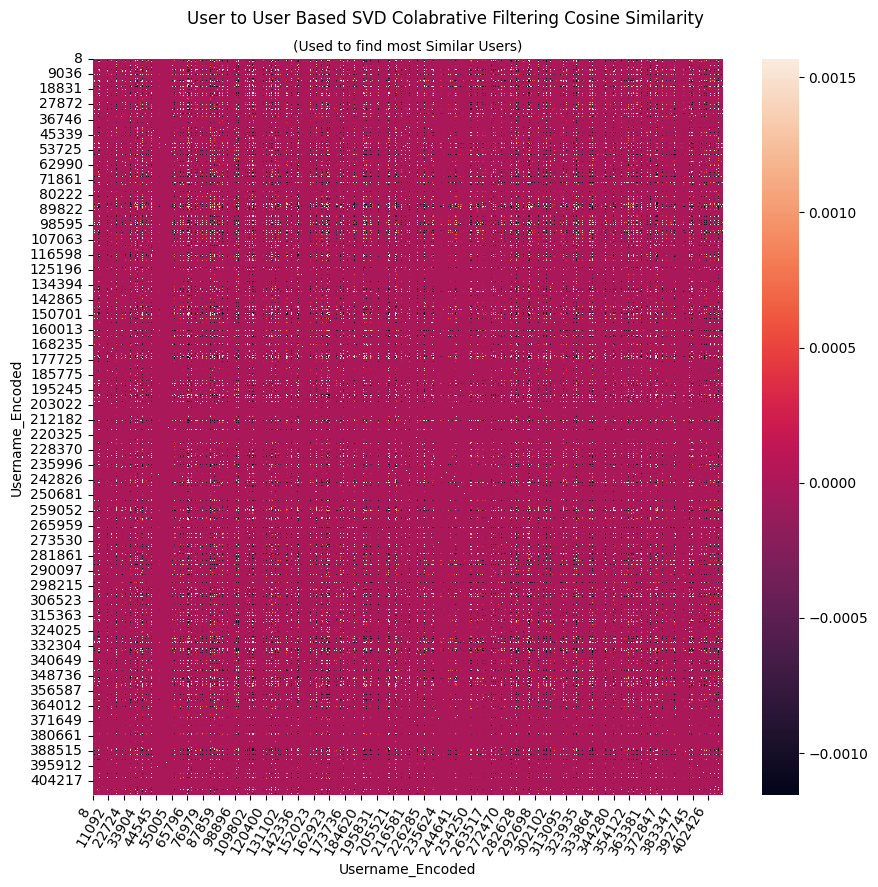

In [19]:
# View your user similarity matrix as a Heatmap
if makeNewHeatmaps:
    plt.figure(figsize=(9,9))
    sns.heatmap(data=UBCF_SVD_cosine_sim_df, annot=False, robust=True)
    plt.xticks(rotation=60, ha='right')  # Rotates x-axis labels for better readability
    plt.suptitle('User to User Based SVD Colabrative Filtering Cosine Similarity', fontsize=12)
    plt.title('(Used to find most Similar Users)', fontsize=10)
    plt.tight_layout()

In [20]:
# Save the user similarity matrix to csv
## This can be used later for finding similar users without recalculating
## But the main point is to show that this file is MASSIVE, 
## the final size was ** 5.41GB ** in size for even a small sample using the original data (0.1%)

## 15,402 * 15,402 = 237,221,604 float64 entries (8bytes each)
## 237,221,604 entries * 8 bytes =  1,897,772,832 bytes
## 1897772832 bytes * 1KB/(1024 bytes) * 1MB/(1024 KB) * 1GB/(1024 MB) = ~1.767 GB of pure (unstructured) information

UBCF_SVD_cosine_sim_df.to_csv("UBCF_SVD_user_similarity_matrix.csv", index=True) # In practice, you might want to use a more efficient storage format for large matrices

### Making use of the User-User Collaborative Filerting Model

In [21]:

def UserBasedCollabFilter(data=pd.DataFrame, user=float, return_self = False, numReturns=int):
    user = float(user)  # Ensure user is float
    if user not in data.index:
        raise ValueError(f"User {user} not found in the data.")
    
    user_corrs = data.loc[user].sort_values(ascending=False)

    if return_self:
        return user_corrs.head(numReturns)
    else:
        return user_corrs.iloc[1:numReturns + 1]  # Skip the first entry (self)

Fifty_corrs_with_u9036 = UserBasedCollabFilter(UBCF_SVD_cosine_sim_df, user=9036, return_self=False, numReturns = 50)
Fifty_corrs_with_u9036

Ten_corrs_with_u9036 = UserBasedCollabFilter(UBCF_SVD_cosine_sim_df, user=9036, return_self=False, numReturns = 10)
Ten_corrs_with_u9036

Hundred_corrs_with_u9036 = UserBasedCollabFilter(UBCF_SVD_cosine_sim_df, user=9036, return_self=False, numReturns = 100)
Hundred_corrs_with_u9036


Ten_corrs_with_u9036

Username_Encoded
122245    7.158971e-10
113914    7.158971e-10
187212    7.158971e-10
295458    7.158971e-10
392601    7.158971e-10
308014    7.158971e-10
307644    7.158971e-10
147846    7.158971e-10
294442    7.158971e-10
287572    7.158971e-10
Name: 9036, dtype: float64

In [22]:
def userBCFRatingPredict(data=pd.Series, BGGId=int, weightedAVG = False,  decimalNums = 1):
    '''
    1. take userId Series data from userBasedCollabFilter method:
    2. loop through the users which were highly correlated with input user from prev method
    3. while looking at the other users, need to pull the rank each user gave the given BGGId
    4. perform a weighted average using the correlations in data as the weights
    '''
    score = 0
    weight = 0
    
    if weightedAVG:
        for u in data.index:
            score += UBCF_User_Item_df_clean_SVD.T[u][BGGId] * data[u]
            weight += data[u]
        return round((score/weight), decimalNums)
    else:
        for u in data.index:
            score += UBCF_User_Item_df_clean_SVD.T[u][BGGId] 
        return round((score/len(data)), decimalNums)

In [23]:
def printPredictionsForUser(userID=int, BGGIds=list, number_std_for_jackpot=1):

    userID_mean = UBCF_User_Item_df_clean_SVD.loc[userID].mean()
    userID_std = UBCF_User_Item_df_clean_SVD.loc[userID].std()

    print(f'User({userID}) Current Average Book Rating {userID_mean}, Standard Dev: {userID_std}')
    print(f'Predicted Ratings for User({userID}) Based on Top(10) Similar Users:')
    n_corrs_with_user = UserBasedCollabFilter(UBCF_SVD_cosine_sim_df, user=userID, return_self=False, numReturns = 25)
    
    for BGGId in BGGIds:
        predicted_rating = userBCFRatingPredict(data=n_corrs_with_user, BGGId=BGGId, weightedAVG=False, decimalNums=3)
        predicted_zscore = (predicted_rating - userID_mean)/userID_std
        if predicted_zscore <= 0:
            print(f'\t - Board Game ({BGGId}): Predicted Rating = {predicted_rating}', '  <-- Miss')  
        elif predicted_zscore >= number_std_for_jackpot:
            print(f'\t - Board Game ({BGGId}): Predicted Rating = {predicted_rating}', f'  <-- JACKPOT!!!! ({predicted_zscore:.2f} STDEVs)')
        else:
            print(f'\t - Board Game ({BGGId}): Predicted Rating = {predicted_rating}', f'  <-- HIT! ({predicted_zscore:.2f} STDEVs)')

    print('\n')

BGGIds_to_test = [1, 13, 494, 5206, 31808, 38054, 332290]  # Example BGGIds

printPredictionsForUser(userID=8, BGGIds=BGGIds_to_test, number_std_for_jackpot=.25)
printPredictionsForUser(userID=42, BGGIds=BGGIds_to_test, number_std_for_jackpot=.25)
printPredictionsForUser(userID=163399, BGGIds=BGGIds_to_test, number_std_for_jackpot=.25)

User(8) Current Average Book Rating 0.0021258503400757023, Standard Dev: 0.10512969167852546
Predicted Ratings for User(8) Based on Top(10) Similar Users:
	 - Board Game (1): Predicted Rating = -0.011   <-- Miss
	 - Board Game (13): Predicted Rating = 0.001   <-- Miss
	 - Board Game (494): Predicted Rating = 0.001   <-- Miss
	 - Board Game (5206): Predicted Rating = -0.0   <-- Miss
	 - Board Game (31808): Predicted Rating = -0.0   <-- Miss
	 - Board Game (38054): Predicted Rating = -0.0   <-- Miss
	 - Board Game (332290): Predicted Rating = 0.0   <-- Miss


User(42) Current Average Book Rating 0.0017006802680316591, Standard Dev: 0.11664236870402032
Predicted Ratings for User(42) Based on Top(10) Similar Users:
	 - Board Game (1): Predicted Rating = -0.009   <-- Miss
	 - Board Game (13): Predicted Rating = 0.001   <-- Miss
	 - Board Game (494): Predicted Rating = 0.002   <-- HIT! (0.00 STDEVs)
	 - Board Game (5206): Predicted Rating = 0.0   <-- Miss
	 - Board Game (31808): Predicted Ra

## Item - Item Colaborative Filtering

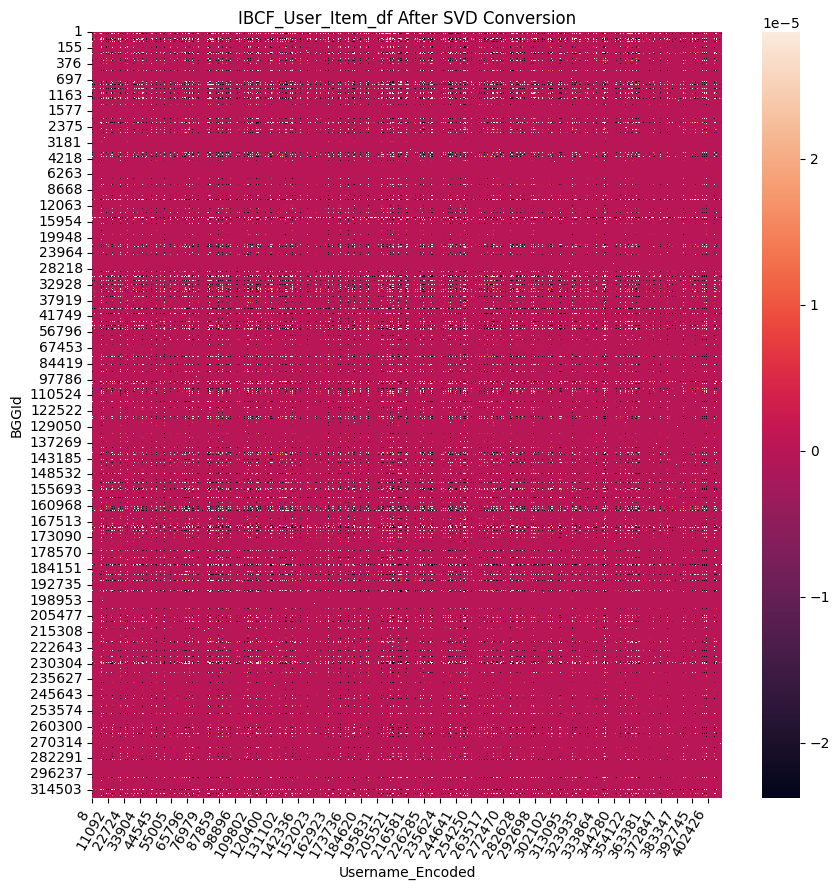

In [25]:
IBCF_User_Item_df_SVD = UBCF_User_Item_df_clean_SVD.T
if makeNewHeatmaps:
    plt.figure(figsize=(9,9))
    sns.heatmap(data=IBCF_User_Item_df_SVD, annot=False, robust=True)
    plt.xticks(rotation=60, ha='right')  # Rotates x-axis labels for better readability
    plt.title("IBCF_User_Item_df After SVD Conversion")
    plt.tight_layout()

In [26]:
IBCF_User_Item_df_SVD

Username_Encoded,8,42,75,141,144,156,169,170,178,211,...,411184,411193,411200,411211,411214,411262,411265,411297,411304,411368
BGGId,,,,,,,,,,,,,,,,,,,,,
1,-9.721040e-13,-1.560358e-11,-3.276991e-04,3.451420e-10,-1.253872e-13,-1.266026e-11,-2.116530e-12,-2.855616e-12,-2.484502e-09,4.207585e-12,...,1.927390e-06,1.825204e-04,-1.504657e-05,1.170139e-04,2.179677e-07,3.215096e-09,-3.498337e-12,-2.411090e-09,-2.041486e-03,7.586005e-06
2,-2.364692e-18,-1.799885e-17,-5.019629e-10,7.681845e-16,-1.541714e-18,-1.879386e-17,7.508423e-18,-9.055367e-18,-3.728646e-15,5.869852e-18,...,2.490998e-12,4.114867e-10,-1.721544e-11,2.150313e-10,3.516131e-13,7.271992e-15,-6.454326e-18,-5.678131e-15,6.247595e-09,1.630142e-11
3,-2.989950e-13,-6.313145e-12,-9.339202e-05,7.037088e-11,-1.752369e-13,-4.370516e-12,1.209915e-12,-5.574113e-13,-7.870094e-10,9.048736e-13,...,7.751083e-07,3.339434e-05,-2.776316e-06,3.589556e-05,8.601341e-08,2.323525e-09,-1.218608e-14,-9.861135e-10,2.662840e-03,2.183531e-06
5,3.816381e-13,3.527849e-12,5.282410e-05,-1.951149e-11,-2.181765e-14,1.916839e-12,-3.976247e-12,1.106595e-12,2.901365e-10,-5.140269e-13,...,-2.937001e-07,-3.390702e-05,1.081619e-06,-4.305812e-06,-3.271597e-08,-9.388208e-10,8.934179e-13,5.301834e-10,-1.580441e-03,3.889148e-07
7,5.098711e-19,4.717840e-18,3.096072e-11,4.879671e-17,-8.105740e-19,7.366961e-19,-4.650038e-18,6.553886e-19,6.717536e-17,6.684472e-19,...,-2.376659e-13,-2.607906e-11,9.159705e-13,-1.612492e-11,-4.473473e-14,-5.759189e-16,1.700901e-18,1.108528e-15,-8.529063e-10,3.832452e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338628,-4.211562e-15,-3.443131e-14,-2.993502e-07,1.615206e-13,7.116592e-15,-4.168907e-16,4.384117e-14,-9.157971e-15,2.264610e-13,-1.365986e-16,...,1.594912e-10,1.741808e-07,-1.042051e-08,-5.630674e-08,-4.900648e-11,-5.390524e-12,-1.679059e-14,-1.004718e-12,1.623971e-06,-1.565401e-08
340466,-4.087891e-15,-4.620891e-14,-3.747449e-08,1.033831e-14,5.837744e-15,1.181697e-15,5.986633e-14,-6.089285e-15,4.490782e-13,-2.684844e-16,...,-7.985499e-10,-4.840554e-08,-1.085933e-09,-1.320965e-08,-4.829892e-11,-3.858735e-12,-1.456714e-14,4.517329e-13,2.106612e-06,-2.199752e-08
342942,-7.217806e-21,-3.649681e-18,1.975832e-11,-7.983483e-18,-2.305859e-19,-7.481402e-20,2.352029e-18,5.105930e-19,-2.090417e-17,5.978314e-20,...,-8.068622e-14,-2.032578e-11,7.949329e-13,1.177239e-11,6.888740e-15,5.108316e-16,-5.632635e-20,5.665554e-17,-1.055952e-10,-9.315128e-13


In [27]:
# Check for constant columns and remove them
constant_columns = [col for col in IBCF_User_Item_df_SVD.columns if IBCF_User_Item_df_SVD[col].nunique() <= 1]
IBCF_User_Item_df_clean_SVD = IBCF_User_Item_df_SVD.drop(columns=constant_columns)
IBCF_User_Item_df_clean_SVD

Username_Encoded,8,42,75,141,144,156,169,170,178,211,...,411184,411193,411200,411211,411214,411262,411265,411297,411304,411368
BGGId,,,,,,,,,,,,,,,,,,,,,
1,-9.721040e-13,-1.560358e-11,-3.276991e-04,3.451420e-10,-1.253872e-13,-1.266026e-11,-2.116530e-12,-2.855616e-12,-2.484502e-09,4.207585e-12,...,1.927390e-06,1.825204e-04,-1.504657e-05,1.170139e-04,2.179677e-07,3.215096e-09,-3.498337e-12,-2.411090e-09,-2.041486e-03,7.586005e-06
2,-2.364692e-18,-1.799885e-17,-5.019629e-10,7.681845e-16,-1.541714e-18,-1.879386e-17,7.508423e-18,-9.055367e-18,-3.728646e-15,5.869852e-18,...,2.490998e-12,4.114867e-10,-1.721544e-11,2.150313e-10,3.516131e-13,7.271992e-15,-6.454326e-18,-5.678131e-15,6.247595e-09,1.630142e-11
3,-2.989950e-13,-6.313145e-12,-9.339202e-05,7.037088e-11,-1.752369e-13,-4.370516e-12,1.209915e-12,-5.574113e-13,-7.870094e-10,9.048736e-13,...,7.751083e-07,3.339434e-05,-2.776316e-06,3.589556e-05,8.601341e-08,2.323525e-09,-1.218608e-14,-9.861135e-10,2.662840e-03,2.183531e-06
5,3.816381e-13,3.527849e-12,5.282410e-05,-1.951149e-11,-2.181765e-14,1.916839e-12,-3.976247e-12,1.106595e-12,2.901365e-10,-5.140269e-13,...,-2.937001e-07,-3.390702e-05,1.081619e-06,-4.305812e-06,-3.271597e-08,-9.388208e-10,8.934179e-13,5.301834e-10,-1.580441e-03,3.889148e-07
7,5.098711e-19,4.717840e-18,3.096072e-11,4.879671e-17,-8.105740e-19,7.366961e-19,-4.650038e-18,6.553886e-19,6.717536e-17,6.684472e-19,...,-2.376659e-13,-2.607906e-11,9.159705e-13,-1.612492e-11,-4.473473e-14,-5.759189e-16,1.700901e-18,1.108528e-15,-8.529063e-10,3.832452e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338628,-4.211562e-15,-3.443131e-14,-2.993502e-07,1.615206e-13,7.116592e-15,-4.168907e-16,4.384117e-14,-9.157971e-15,2.264610e-13,-1.365986e-16,...,1.594912e-10,1.741808e-07,-1.042051e-08,-5.630674e-08,-4.900648e-11,-5.390524e-12,-1.679059e-14,-1.004718e-12,1.623971e-06,-1.565401e-08
340466,-4.087891e-15,-4.620891e-14,-3.747449e-08,1.033831e-14,5.837744e-15,1.181697e-15,5.986633e-14,-6.089285e-15,4.490782e-13,-2.684844e-16,...,-7.985499e-10,-4.840554e-08,-1.085933e-09,-1.320965e-08,-4.829892e-11,-3.858735e-12,-1.456714e-14,4.517329e-13,2.106612e-06,-2.199752e-08
342942,-7.217806e-21,-3.649681e-18,1.975832e-11,-7.983483e-18,-2.305859e-19,-7.481402e-20,2.352029e-18,5.105930e-19,-2.090417e-17,5.978314e-20,...,-8.068622e-14,-2.032578e-11,7.949329e-13,1.177239e-11,6.888740e-15,5.108316e-16,-5.632635e-20,5.665554e-17,-1.055952e-10,-9.315128e-13


In [28]:
# Compute cosine similarity between users
cosine_sim_matrix = cosine_similarity(IBCF_User_Item_df_clean_SVD)

# Convert to a DataFrame for ease of use
IBCF_SVD_cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=IBCF_User_Item_df_clean_SVD.index, columns=IBCF_User_Item_df_clean_SVD.index)
IBCF_SVD_cosine_sim_df

BGGId,1,2,3,5,7,9,10,11,12,13,...,330608,331050,332290,332386,332800,338628,340466,342942,343905,346703
BGGId,,,,,,,,,,,,,,,,,,,,,
1,1.000000e+00,3.280766e-10,3.181707e-05,-8.663061e-06,-8.276385e-12,7.229371e-14,1.551491e-07,-3.046556e-04,-1.912208e-05,-4.551443e-04,...,1.653445e-13,3.158852e-15,-1.946766e-12,1.939655e-13,3.297826e-12,1.524889e-07,2.841621e-08,3.915695e-12,6.883592e-13,2.667219e-12
2,3.280766e-10,1.000000e+00,5.382781e-11,-2.359644e-11,-4.066478e-17,1.394085e-19,1.154068e-13,-3.479137e-11,-5.022490e-11,6.535259e-10,...,3.234891e-19,6.083598e-20,-5.736085e-18,3.061904e-19,8.121476e-18,2.774556e-13,2.014269e-13,2.938108e-18,4.757807e-19,5.924984e-18
3,3.181707e-05,5.382781e-11,1.000000e+00,-1.993907e-06,-3.145739e-12,1.793196e-14,1.707889e-08,-6.430629e-05,-3.945642e-06,7.834113e-06,...,2.447148e-14,2.691727e-15,-6.841900e-13,4.032599e-14,7.213100e-13,2.456801e-08,1.527981e-08,3.629483e-13,1.285087e-13,5.448826e-13
5,-8.663061e-06,-2.359644e-11,-1.993907e-06,1.000000e+00,2.195849e-12,-3.873549e-15,1.915092e-09,1.010675e-05,8.732088e-07,-5.551594e-05,...,-1.291002e-14,-5.972206e-15,7.956466e-13,-1.333157e-14,-3.968863e-13,-2.074030e-08,-2.313905e-08,9.450475e-14,-6.027246e-14,-2.182696e-13
7,-8.276385e-12,-4.066478e-17,-3.145739e-12,2.195849e-12,1.000000e+00,-2.648843e-20,8.733656e-15,-1.774719e-11,1.721215e-12,-9.679490e-11,...,-6.703772e-21,7.085477e-21,-4.820059e-19,-2.510120e-20,-9.377652e-19,-3.674721e-14,-4.356518e-14,-8.990007e-19,-3.773630e-19,-1.222093e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338628,1.524889e-07,2.774556e-13,2.456801e-08,-2.074030e-08,-3.674721e-14,1.319533e-17,-1.897620e-10,1.672750e-06,9.721338e-09,-8.392796e-07,...,1.075192e-16,1.042920e-16,-1.374561e-14,-4.168441e-17,7.812517e-15,1.000000e+00,1.423032e-09,1.135629e-15,4.990872e-15,2.844893e-15
340466,2.841621e-08,2.014269e-13,1.527981e-08,-2.313905e-08,-4.356518e-14,9.322808e-18,-3.137806e-10,2.539909e-06,2.456959e-08,-3.629749e-07,...,-1.797948e-17,1.133798e-16,-1.339003e-14,-1.171416e-16,7.525784e-15,1.423032e-09,1.000000e+00,1.880485e-14,1.066141e-14,2.819309e-15
342942,3.915695e-12,2.938108e-18,3.629483e-13,9.450475e-14,-8.990007e-19,1.982128e-21,1.327026e-14,-1.209658e-11,-1.251742e-13,-2.340895e-11,...,-6.607355e-21,-7.704587e-21,7.565407e-19,3.451137e-21,-9.318917e-20,1.135629e-15,1.880485e-14,1.000000e+00,2.249945e-19,1.655218e-19


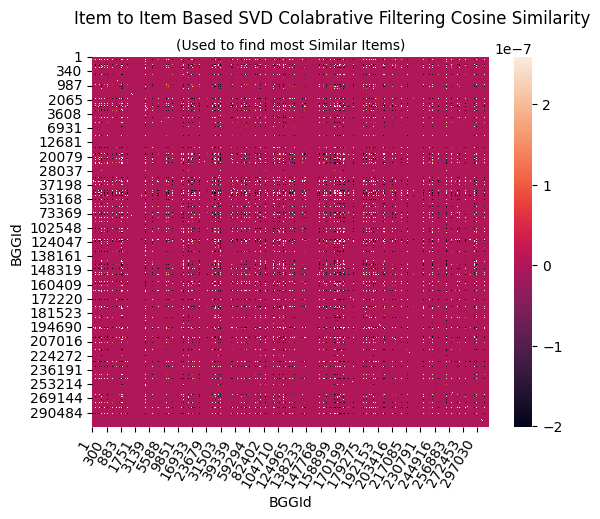

In [29]:
if makeNewHeatmaps:
    sns.heatmap(data=IBCF_SVD_cosine_sim_df, annot=False, robust=True)
    plt.suptitle('Item to Item Based SVD Colabrative Filtering Cosine Similarity', fontsize=12)
    plt.xticks(rotation=60, ha='right')  # Rotates x-axis labels for better readability
    plt.title('(Used to find most Similar Items)', fontsize=10)

In [30]:
# Save the user similarity matrix to csv
IBCF_SVD_cosine_sim_df.to_csv("IBCF_SVD_item_similarity_matrix.csv", index=True) # In practice, you might want to use a more efficient storage format for large matrices

In [31]:
def ItemBasedCollabFilter(data=pd.DataFrame, items=[], return_self = False, numReturns = int):
    returns = {}
    for item in items:
        if return_self:
            returns[item] = data[:][item].sort_values(ascending=False)[0:numReturns]
        else:
            returns[item] = data[:][item].sort_values(ascending=False)[1:numReturns+1]
    return returns
    
# Create a list of items to test
items_list = [1, 300, 883]

# Get top 5 correlated items for each item in the list
N_corrs_with_item = ItemBasedCollabFilter(IBCF_SVD_cosine_sim_df, items=items_list, return_self=False, numReturns = 5)
N_corrs_with_item


{1: BGGId
 12333     0.062862
 28143     0.007963
 70323     0.006771
 2651      0.005642
 161936    0.005118
 Name: 1, dtype: float64,
 300: BGGId
 21763     0.234905
 148228    0.000129
 14996     0.000079
 174430    0.000074
 129622    0.000060
 Name: 300, dtype: float64,
 883: BGGId
 70323    1.467376e-10
 14996    1.136996e-10
 28143    7.386974e-11
 9209     6.421378e-11
 40692    6.136777e-11
 Name: 883, dtype: float64}

In [32]:
def itemBCFRatingPredict(data=pd.Series):
    '''
    1. take Series data from itemBasedCollabFilter method:
    2. loop through the items which were highly correlated with input item from prev method
    3. Return the list of len(numReturn) number of items
    '''
    
    ret_list = []
    for BG in data.index:
        #ret_list.append(b.where(b[''] == BG).dropna()['AuthorTitleString'].values[0])
        ret_list.append(BG)
    return ret_list

itemBCFRatingPredict(data=N_corrs_with_item[1])

[12333, 28143, 70323, 2651, 161936]